In [1]:
!pip install PyPDF2 pdfplumber python-docx pandas nltk scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.8 MB/s eta 0:00:00a 0:00:01


In [4]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import PyPDF2
import pdfplumber
from docx import Document

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yogdeepbenchimath/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yogdeepbenchimath/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yogdeepbenchimath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yogdeepbenchimath/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yogdeepbenchimath/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
def create_directory_structure():
    directories = [
        'data/resumes/data_science',
        'data/resumes/software_development', 
        'data/resumes/hr',
        'data/resumes/marketing',
        'data/resumes/finance',
        'data/processed',
        'models',
        'reports'
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    print("Directory structure created successfully!")

create_directory_structure()

Directory structure created successfully!


In [5]:
class ResumeTextExtractor:
    
    def __init__(self):
        self.supported_formats = ['.pdf', '.docx', '.txt']
    
    def extract_text_from_pdf(self, file_path):
        text = ""
    
        try:
            with pdfplumber.open(file_path) as pdf:
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + "\n"
            if text.strip():
                return text
        except Exception as e:
            print(f"pdfplumber failed for {file_path}: {e}")
        
        # Method 2: Using PyPDF2 (fallback)
        try:
            with open(file_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                for page in pdf_reader.pages:
                    text += page.extract_text() + "\n"
        except Exception as e:
            print(f"PyPDF2 failed for {file_path}: {e}")
        
        return text
    
    def extract_text_from_docx(self, file_path):
        try:
            doc = Document(file_path)
            text = ""
            for paragraph in doc.paragraphs:
                text += paragraph.text + "\n"
            return text
        except Exception as e:
            print(f"Error extracting from {file_path}: {e}")
            return ""
    
    def extract_text_from_txt(self, file_path):
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                return file.read()
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return ""
    
    def extract_text(self, file_path):
        _, ext = os.path.splitext(file_path.lower())
        
        if ext == '.pdf':
            return self.extract_text_from_pdf(file_path)
        elif ext == '.docx':
            return self.extract_text_from_docx(file_path)
        elif ext == '.txt':
            return self.extract_text_from_txt(file_path)
        else:
            print(f"Unsupported file format: {ext}")
            return ""

extractor = ResumeTextExtractor()

In [5]:
def process_resumes_from_directory(base_path='data/resumes'):
    data = []
    
    categories = ['data_science', 'software_development', 'hr', 'marketing', 'finance']
    
    for category in categories:
        category_path = os.path.join(base_path, category)
        if os.path.exists(category_path):
            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)
                if os.path.isfile(file_path):
                    print(f"Processing: {filename}")
                    text = extractor.extract_text(file_path)
                    if text.strip():  # Only add if text was extracted
                        data.append({
                            'filename': filename,
                            'category': category,
                            'text': text,
                            'text_length': len(text),
                            'word_count': len(text.split())
                        })
    
    return pd.DataFrame(data)

In [6]:
sample_resumes = [
    {
        'filename': 'ds_resume.pdf.pdf',
        'category': 'data_science',
        'text': 'Experienced Data Scientist with expertise in Python, Machine Learning, pandas, numpy, scikit-learn, tensorflow. PhD in Statistics. Built predictive models using regression, classification algorithms. Experience with SQL, Tableau, data visualization.',
        'text_length': 250,
        'word_count': 35
    },
    {
        'filename': 'software_resume.pdf', 
        'category': 'software_development',
        'text': 'Full Stack Developer with 5 years experience in JavaScript, React, Node.js, Python, Django. Built responsive web applications, RESTful APIs. Experience with Git, Docker, AWS, agile methodologies. Strong problem-solving skills.',
        'text_length': 220,
        'word_count': 32
    },
    {
        'filename': 'hr_pdf.pdf',
        'category': 'hr', 
        'text': 'HR Manager with 7 years experience in recruitment, employee relations, performance management, payroll administration. Expert in hiring processes, onboarding, benefits administration, conflict resolution, policy development.',
        'text_length': 200,
        'word_count': 28
    }
]

df = pd.DataFrame(sample_resumes)
print("Sample dataset created!")
print(df.head())

Sample dataset created!
              filename              category  \
0    ds_resume.pdf.pdf          data_science   
1  software_resume.pdf  software_development   
2           hr_pdf.pdf                    hr   

                                                text  text_length  word_count  
0  Experienced Data Scientist with expertise in P...          250          35  
1  Full Stack Developer with 5 years experience i...          220          32  
2  HR Manager with 7 years experience in recruitm...          200          28  


In [7]:
class JobCategoryClassifier:
    
    def __init__(self):
        self.category_keywords = {
            'data_science': [
                'python', 'r', 'sql', 'scala', 'julia',
                'pandas', 'numpy', 'scikit-learn', 'tensorflow', 'pytorch', 'keras',
                'matplotlib', 'seaborn', 'plotly', 'scipy', 'statsmodels',
                'machine learning', 'deep learning', 'neural network', 'regression',
                'classification', 'clustering', 'nlp', 'computer vision',
                'predictive modeling', 'statistical analysis', 'data mining',
                'jupyter', 'tableau', 'power bi', 'spark', 'hadoop', 'kafka',
                'aws', 'azure', 'gcp', 'docker', 'kubernetes',
                'data scientist', 'data analyst', 'ml engineer', 'research scientist'
            ],
            
            'software_development': [
                'java', 'javascript', 'python', 'c++', 'c#', 'php', 'ruby', 'go',
                'typescript', 'swift', 'kotlin', 'rust',
                'react', 'angular', 'vue', 'html', 'css', 'bootstrap', 'jquery',
                'redux', 'webpack', 'sass', 'less',
                'node.js', 'express', 'django', 'flask', 'spring', 'laravel',
                'rails', 'asp.net', 'fastapi',
                'mysql', 'postgresql', 'mongodb', 'redis', 'elasticsearch',
                'oracle', 'sqlite', 'cassandra',
                'git', 'github', 'gitlab', 'jenkins', 'docker', 'kubernetes',
                'aws', 'azure', 'terraform', 'ansible',
                'agile', 'scrum', 'tdd', 'ci/cd', 'microservices', 'api', 'rest',
                'software engineer', 'full stack', 'frontend', 'backend', 'devops'
            ],
            
            'hr': [
                'recruitment', 'hiring', 'talent acquisition', 'onboarding',
                'employee relations', 'performance management', 'compensation',
                'benefits', 'payroll', 'hr policies', 'compliance',
                'training and development', 'learning and development', 'succession planning',
                'organizational development', 'change management', 'employee engagement',
                'diversity and inclusion', 'workplace culture',
                'hris', 'ats', 'workday', 'successfactors', 'bamboohr',
                'linkedin recruiter', 'indeed', 'glassdoor',
                'interviewing', 'conflict resolution', 'negotiation', 'communication',
                'leadership development', 'coaching', 'mentoring',
                'hr manager', 'hr business partner', 'recruiter', 'hr generalist'
            ],
            
            'marketing': [
                'digital marketing', 'social media', 'content marketing', 'seo', 'sem',
                'ppc', 'google ads', 'facebook ads', 'email marketing', 'marketing automation',
                'google analytics', 'adobe analytics', 'hubspot', 'salesforce',
                'mailchimp', 'hootsuite', 'buffer', 'canva', 'photoshop',
                'brand management', 'campaign management', 'lead generation',
                'conversion optimization', 'a/b testing', 'customer acquisition',
                'market research', 'competitive analysis',
                'copywriting', 'content creation', 'graphic design', 'video marketing',
                'influencer marketing', 'public relations', 'event marketing',
                'marketing manager', 'digital marketer', 'content manager', 'brand manager'
            ],
            
            'finance': [
                'financial analysis', 'financial planning', 'budgeting', 'forecasting',
                'accounting', 'bookkeeping', 'audit', 'tax', 'compliance',
                'investment banking', 'portfolio management', 'risk management',
                'credit analysis', 'equity research', 'fixed income', 'derivatives',
                'excel', 'vba', 'sql', 'tableau', 'power bi', 'sap', 'oracle',
                'quickbooks', 'peachtree', 'bloomberg', 'reuters',
                'cpa', 'cfa', 'frm', 'acca', 'cima', 'fca',
                'financial modeling', 'valuation', 'merger', 'acquisition',
                'due diligence', 'financial reporting', 'variance analysis',
                'financial analyst', 'accountant', 'investment banker', 'controller'
            ]
        }
        
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    def preprocess_text(self, text):

        text = text.lower()
        
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        text = ' '.join(text.split())

        tokens = word_tokenize(text)

        tokens = [token for token in tokens if token not in self.stop_words and len(token) > 2]
        
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    def extract_features(self, text):
        processed_text = self.preprocess_text(text)
        tokens = processed_text.split()
        
        features = {}
        
        for category, keywords in self.category_keywords.items():
            score = 0
            matched_keywords = []
            
            for keyword in keywords:
                if ' ' in keyword:
                    if keyword in text.lower():
                        score += 2  # Higher weight for exact phrase match
                        matched_keywords.append(keyword)
                else:
                    # Single word keywords
                    keyword_variations = [keyword, self.stemmer.stem(keyword), self.lemmatizer.lemmatize(keyword)]
                    for token in tokens:
                        if any(var in token or token in var for var in keyword_variations):
                            score += 1
                            matched_keywords.append(keyword)
                            break
            
            features[f'{category}_score'] = score
            features[f'{category}_keywords'] = matched_keywords
            features[f'{category}_density'] = score / len(tokens) if tokens else 0
        
        features['total_words'] = len(tokens)
        features['unique_words'] = len(set(tokens))
        features['avg_word_length'] = np.mean([len(word) for word in tokens]) if tokens else 0
        
        experience_pattern = r'(\d+)[\s\-]*(?:years?|yrs?)\s*(?:of\s*)?(?:experience|exp)'
        experience_matches = re.findall(experience_pattern, text.lower())
        features['experience_years'] = max([int(x) for x in experience_matches]) if experience_matches else 0
        
        return features


In [11]:
classifier = JobCategoryClassifier()

def extract_features_for_dataset(df):
    features_list = []
    
    for idx, row in df.iterrows():
        print(f"Extracting features for resume {idx+1}/{len(df)}")
        features = classifier.extract_features(row['text'])
        features['filename'] = row['filename']
        features['true_category'] = row['category']
        features_list.append(features)
    
    return pd.DataFrame(features_list)


features_df = extract_features_for_dataset(df)
print("Features extracted!")
print(features_df.head())

Extracting features for resume 1/3
Extracting features for resume 2/3
Extracting features for resume 3/3
Features extracted!
   data_science_score                              data_science_keywords  \
0                  15  [python, r, sql, pandas, numpy, scikit-learn, ...   
1                   4                           [python, r, aws, docker]   
2                   1                                                [r]   

   data_science_density  software_development_score  \
0              0.576923                           6   
1              0.153846                          18   
2              0.050000                           0   

                       software_development_keywords  \
0     [python, go, mysql, postgresql, redis, sqlite]   
1  [java, javascript, python, go, react, webpack,...   
2                                                 []   

   software_development_density  hr_score  \
0                      0.230769         1   
1                      0.692308   

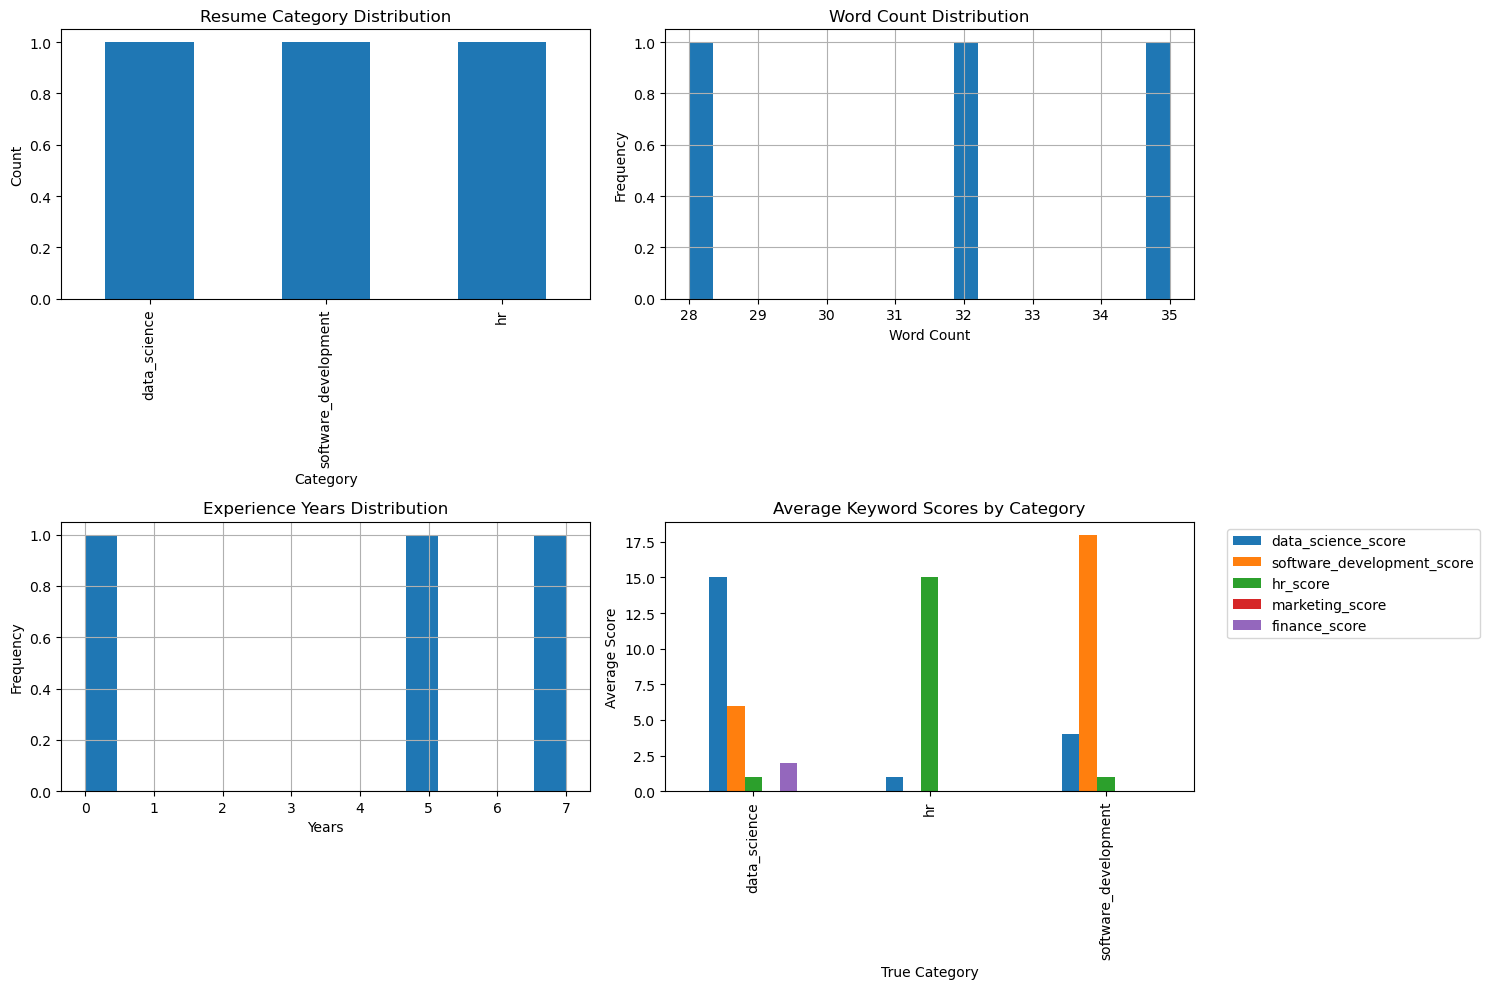

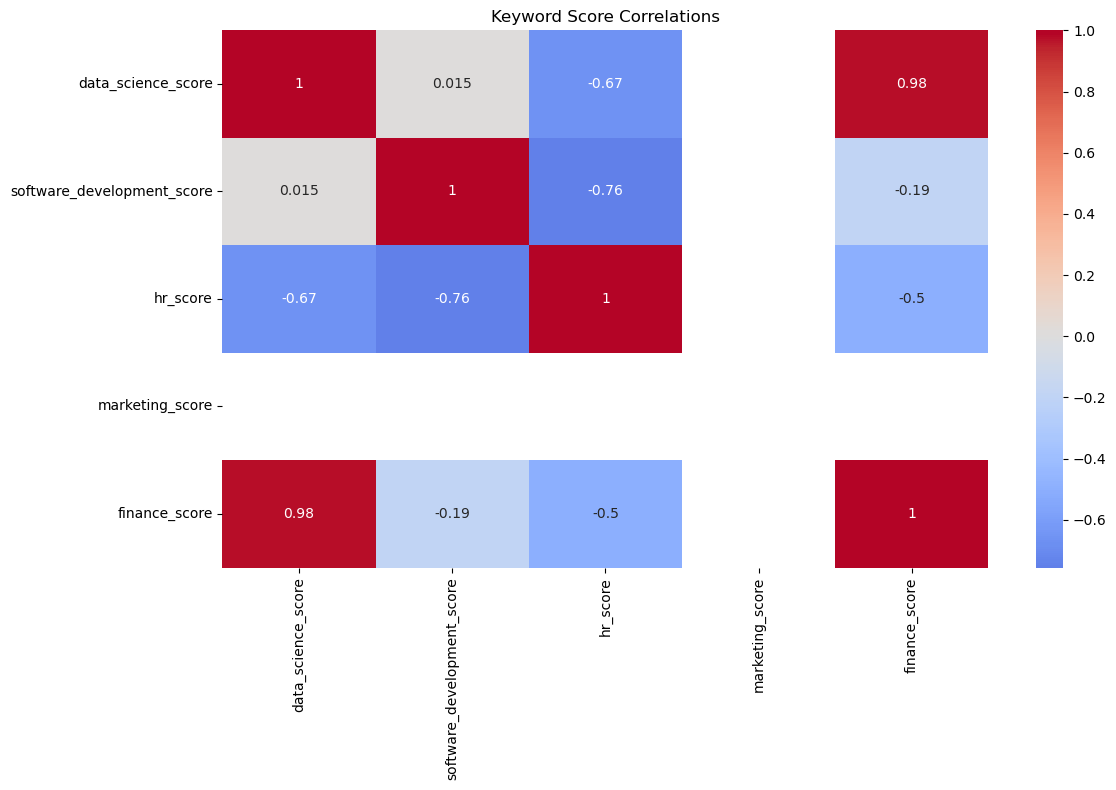

In [12]:
def perform_eda(df, features_df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    df['category'].value_counts().plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Resume Category Distribution')
    axes[0,0].set_xlabel('Category')
    axes[0,0].set_ylabel('Count')
    
    df['word_count'].hist(bins=20, ax=axes[0,1])
    axes[0,1].set_title('Word Count Distribution')
    axes[0,1].set_xlabel('Word Count')
    axes[0,1].set_ylabel('Frequency')
    
    features_df['experience_years'].hist(bins=15, ax=axes[1,0])
    axes[1,0].set_title('Experience Years Distribution')
    axes[1,0].set_xlabel('Years')
    axes[1,0].set_ylabel('Frequency')
    
    score_columns = [col for col in features_df.columns if col.endswith('_score')]
    category_scores = features_df.groupby('true_category')[score_columns].mean()
    category_scores.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Average Keyword Scores by Category')
    axes[1,1].set_xlabel('True Category')
    axes[1,1].set_ylabel('Average Score')
    axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    score_columns = [col for col in features_df.columns if col.endswith('_score')]
    correlation_matrix = features_df[score_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Keyword Score Correlations')
    plt.tight_layout()
    plt.show()

perform_eda(df, features_df)

In [13]:
def prepare_ml_data(df, features_df):

    feature_columns = [col for col in features_df.columns if col.endswith('_score') or col.endswith('_density')]
    feature_columns.extend(['total_words', 'unique_words', 'avg_word_length', 'experience_years'])
    
    X = features_df[feature_columns].fillna(0)
    y = features_df['true_category']
    

    X_text = df['text']
    
    return X, X_text, y, feature_columns

X_features, X_text, y, feature_columns = prepare_ml_data(df, features_df)

print("Feature columns:", feature_columns)
print("X_features shape:", X_features.shape)
print("Target distribution:\n", y.value_counts())

Feature columns: ['data_science_score', 'data_science_density', 'software_development_score', 'software_development_density', 'hr_score', 'hr_density', 'marketing_score', 'marketing_density', 'finance_score', 'finance_density', 'total_words', 'unique_words', 'avg_word_length', 'experience_years']
X_features shape: (3, 14)
Target distribution:
 true_category
data_science            1
software_development    1
hr                      1
Name: count, dtype: int64


In [14]:
class RuleBasedClassifier:
    
    def __init__(self, job_classifier):
        self.job_classifier = job_classifier
        
    def predict(self, texts):
        predictions = []
        confidences = []
        
        for text in texts:
            features = self.job_classifier.extract_features(text)
            
            # Get scores for each category
            scores = {
                'data_science': features['data_science_score'],
                'software_development': features['software_development_score'], 
                'hr': features['hr_score'],
                'marketing': features['marketing_score'],
                'finance': features['finance_score']
            }
            
            predicted_category = max(scores, key=scores.get)
            max_score = scores[predicted_category]
            
            scores_list = sorted(scores.values(), reverse=True)
            if len(scores_list) > 1 and scores_list[0] > 0:
                confidence = (scores_list[0] - scores_list[1]) / scores_list[0]
            else:
                confidence = 0.0 if max_score == 0 else 1.0
                
            predictions.append(predicted_category)
            confidences.append(confidence)
            
        return predictions, confidences


In [15]:
rule_classifier = RuleBasedClassifier(classifier)
rule_predictions, rule_confidences = rule_classifier.predict(df['text'])

print("Rule-based Classification Results:")
for i, (true_cat, pred_cat, conf) in enumerate(zip(y, rule_predictions, rule_confidences)):
    print(f"Resume {i+1}: True={true_cat}, Predicted={pred_cat}, Confidence={conf:.2f}")

Rule-based Classification Results:
Resume 1: True=data_science, Predicted=data_science, Confidence=0.60
Resume 2: True=software_development, Predicted=software_development, Confidence=0.78
Resume 3: True=hr, Predicted=hr, Confidence=0.93


In [16]:
def train_ml_models(X_features, X_text, y):

    X_feat_train, X_feat_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
        X_features, X_text, y, test_size=0.3, random_state=42, stratify=y
    )
    
    models = {}
    results = {}

    feature_models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(kernel='rbf', random_state=42, probability=True)
    }
    
    print("Training feature-based models...")
    for name, model in feature_models.items():
        model.fit(X_feat_train, y_train)
        y_pred = model.predict(X_feat_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        models[f'{name}_features'] = model
        results[f'{name}_features'] = {
            'accuracy': accuracy,
            'predictions': y_pred,
            'model_type': 'features'
        }
        print(f"{name} (Features) Accuracy: {accuracy:.3f}")

    text_models = {
        'Naive Bayes': Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
            ('nb', MultinomialNB())
        ]),
        'Logistic Regression Text': Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
            ('lr', LogisticRegression(random_state=42, max_iter=1000))
        ])
    }
    
    print("\nTraining text-based models...")
    for name, model in text_models.items():
        model.fit(X_text_train, y_train)
        y_pred = model.predict(X_text_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        models[f'{name}_text'] = model
        results[f'{name}_text'] = {
            'accuracy': accuracy,
            'predictions': y_pred,
            'model_type': 'text'
        }
        print(f"{name} (Text) Accuracy: {accuracy:.3f}")
    
    return models, results, (X_feat_test, X_text_test, y_test)

if len(df) >= 5:  
    models, results, test_data = train_ml_models(X_features, X_text, y)
else:
    print("Not enough samples for proper ML training. Need at least 5 samples per category.")
    models, results, test_data = {}, {}, (None, None, None)


def evaluate_models(models, results, test_data, rule_predictions, y_true):
    """Evaluate and compare all models"""
    
    X_feat_test, X_text_test, y_test = test_data
    
    print("="*50)
    print("MODEL EVALUATION RESULTS")
    print("="*50)
    
    if len(rule_predictions) == len(y_true):
        rule_accuracy = accuracy_score(y_true, rule_predictions)
        print(f"Rule-based Classifier Accuracy: {rule_accuracy:.3f}")
        print("\nRule-based Classification Report:")
        print(classification_report(y_true, rule_predictions))
    
    if X_feat_test is not None:
        print("\n" + "="*30)
        print("MACHINE LEARNING MODELS")
        print("="*30)
        
        for model_name, result in results.items():
            print(f"\n{model_name} - Accuracy: {result['accuracy']:.3f}")
            print("Classification Report:")
            print(classification_report(y_test, result['predictions']))
    
    if 'Random Forest_features' in models:
        rf_model = models['Random Forest_features']
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Most Important Features (Random Forest):")
        print(feature_importance.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        top_features = feature_importance.head(10)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 10 Feature Importances (Random Forest)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

evaluate_models(models, results, test_data, rule_predictions, y)

Not enough samples for proper ML training. Need at least 5 samples per category.
MODEL EVALUATION RESULTS
Rule-based Classifier Accuracy: 1.000

Rule-based Classification Report:
                      precision    recall  f1-score   support

        data_science       1.00      1.00      1.00         1
                  hr       1.00      1.00      1.00         1
software_development       1.00      1.00      1.00         1

            accuracy                           1.00         3
           macro avg       1.00      1.00      1.00         3
        weighted avg       1.00      1.00      1.00         3



In [17]:
class ResumeClassificationPipeline:
    
    def __init__(self):
        self.text_extractor = ResumeTextExtractor()
        self.job_classifier = JobCategoryClassifier()
        self.rule_classifier = RuleBasedClassifier(self.job_classifier)
        self.ml_models = {}
        self.best_model = None
        self.best_model_type = None
        
    def load_models(self, models_dict):

        self.ml_models = models_dict
        
        self.best_model = self.rule_classifier
        self.best_model_type = 'rule_based'
    
    def process_single_resume(self, file_path_or_text, is_file_path=True):
        
        if is_file_path:
            text = self.text_extractor.extract_text(file_path_or_text)
            filename = os.path.basename(file_path_or_text)
        else:
            text = file_path_or_text
            filename = "direct_text_input"
        
        if not text.strip():
            return {
                'filename': filename,
                'error': 'Could not extract text from file',
                'predicted_category': None,
                'confidence': 0.0
            }
        
        features = self.job_classifier.extract_features(text)
        
        predictions, confidences = self.rule_classifier.predict([text])
        predicted_category = predictions[0]
        confidence = confidences[0]
        
        if confidence >= 0.7:
            confidence_level = "HIGH"
        elif confidence >= 0.4:
            confidence_level = "MEDIUM"
        else:
            confidence_level = "LOW"
        
        return {
            'filename': filename,
            'predicted_category': predicted_category,
            'confidence': confidence,
            'confidence_level': confidence_level,
            'features': features,
            'text_preview': text[:200] + "..." if len(text) > 200 else text,
            'word_count': len(text.split()),
            'error': None
        }
    
    def process_bulk_resumes(self, file_paths):
        results = []
        
        for i, file_path in enumerate(file_paths):
            print(f"Processing {i+1}/{len(file_paths)}: {os.path.basename(file_path)}")
            result = self.process_single_resume(file_path)
            results.append(result)
        
        return results
    
    def generate_classification_report(self, results):
        
        df_results = pd.DataFrame(results)
        
        total_resumes = len(results)
        successful_classifications = len([r for r in results if r['error'] is None])
        
        category_distribution = df_results['predicted_category'].value_counts()
        confidence_distribution = df_results['confidence_level'].value_counts()
        
        report = {
            'summary': {
                'total_resumes_processed': total_resumes,
                'successful_classifications': successful_classifications,
                'success_rate': successful_classifications / total_resumes * 100,
                'average_confidence': df_results['confidence'].mean()
            },
            'category_distribution': category_distribution.to_dict(),
            'confidence_distribution': confidence_distribution.to_dict(),
            'detailed_results': df_results
        }
        
        return report

In [19]:
pipeline = ResumeClassificationPipeline()
pipeline.load_models(models)

test_resumes = [
    {
        'filename': 'test_ds.txt.txt',
        'text': 'Data Scientist with 5 years experience in Python, pandas, scikit-learn, tensorflow. Built machine learning models for predictive analytics. PhD in Statistics with expertise in regression analysis, classification algorithms, and deep learning. Experience with SQL, Tableau, and big data technologies like Spark.'
    },
    {
        'filename': 'test_dev.txt.txt', 
        'text': 'Full Stack Software Developer with 4 years experience in JavaScript, React, Node.js, Python. Built scalable web applications using modern frameworks. Experience with RESTful APIs, Docker, AWS, Git, and agile development methodologies. Strong problem-solving and debugging skills.'
    },
    {
        'filename': 'test_hr.txt',
        'text': 'HR Manager with 6 years experience in talent acquisition, employee relations, and performance management. Expert in recruitment processes, onboarding, benefits administration, and HR policy development. Experience with HRIS systems and conflict resolution.'
    }
]


print("Testing Resume Classification Pipeline")
print("="*50)

Testing Resume Classification Pipeline


In [21]:
test_results = []
for resume in test_resumes:
    result = pipeline.process_single_resume(resume['text'], is_file_path=False)
    result['filename'] = resume['filename'] 
    test_results.append(result)
    
    print(f"\nResume: {result['filename']}")
    print(f"Predicted Category: {result['predicted_category']}")
    print(f"Confidence: {result['confidence']:.3f} ({result['confidence_level']})")
    print(f"Word Count: {result['word_count']}")
    if result['error']:
        print(f"Error: {result['error']}")

classification_report = pipeline.generate_classification_report(test_results)
print(f"\n\nCLASSIFICATION REPORT")
print("="*50)
print(f"Total Resumes: {classification_report['summary']['total_resumes_processed']}")
print(f"Success Rate: {classification_report['summary']['success_rate']:.1f}%")
print(f"Average Confidence: {classification_report['summary']['average_confidence']:.3f}")
print(f"\nCategory Distribution:")
for category, count in classification_report['category_distribution'].items():
    print(f"  {category}: {count}")


Resume: test_ds.txt.txt
Predicted Category: data_science
Confidence: 0.588 (MEDIUM)
Word Count: 41

Resume: test_dev.txt.txt
Predicted Category: software_development
Confidence: 0.688 (MEDIUM)
Word Count: 36

Resume: test_hr.txt
Predicted Category: hr
Confidence: 0.938 (HIGH)
Word Count: 32


CLASSIFICATION REPORT
Total Resumes: 3
Success Rate: 100.0%
Average Confidence: 0.738

Category Distribution:
  data_science: 1
  software_development: 1
  hr: 1


Detailed report saved to: reports/resume_classification_report.xlsx


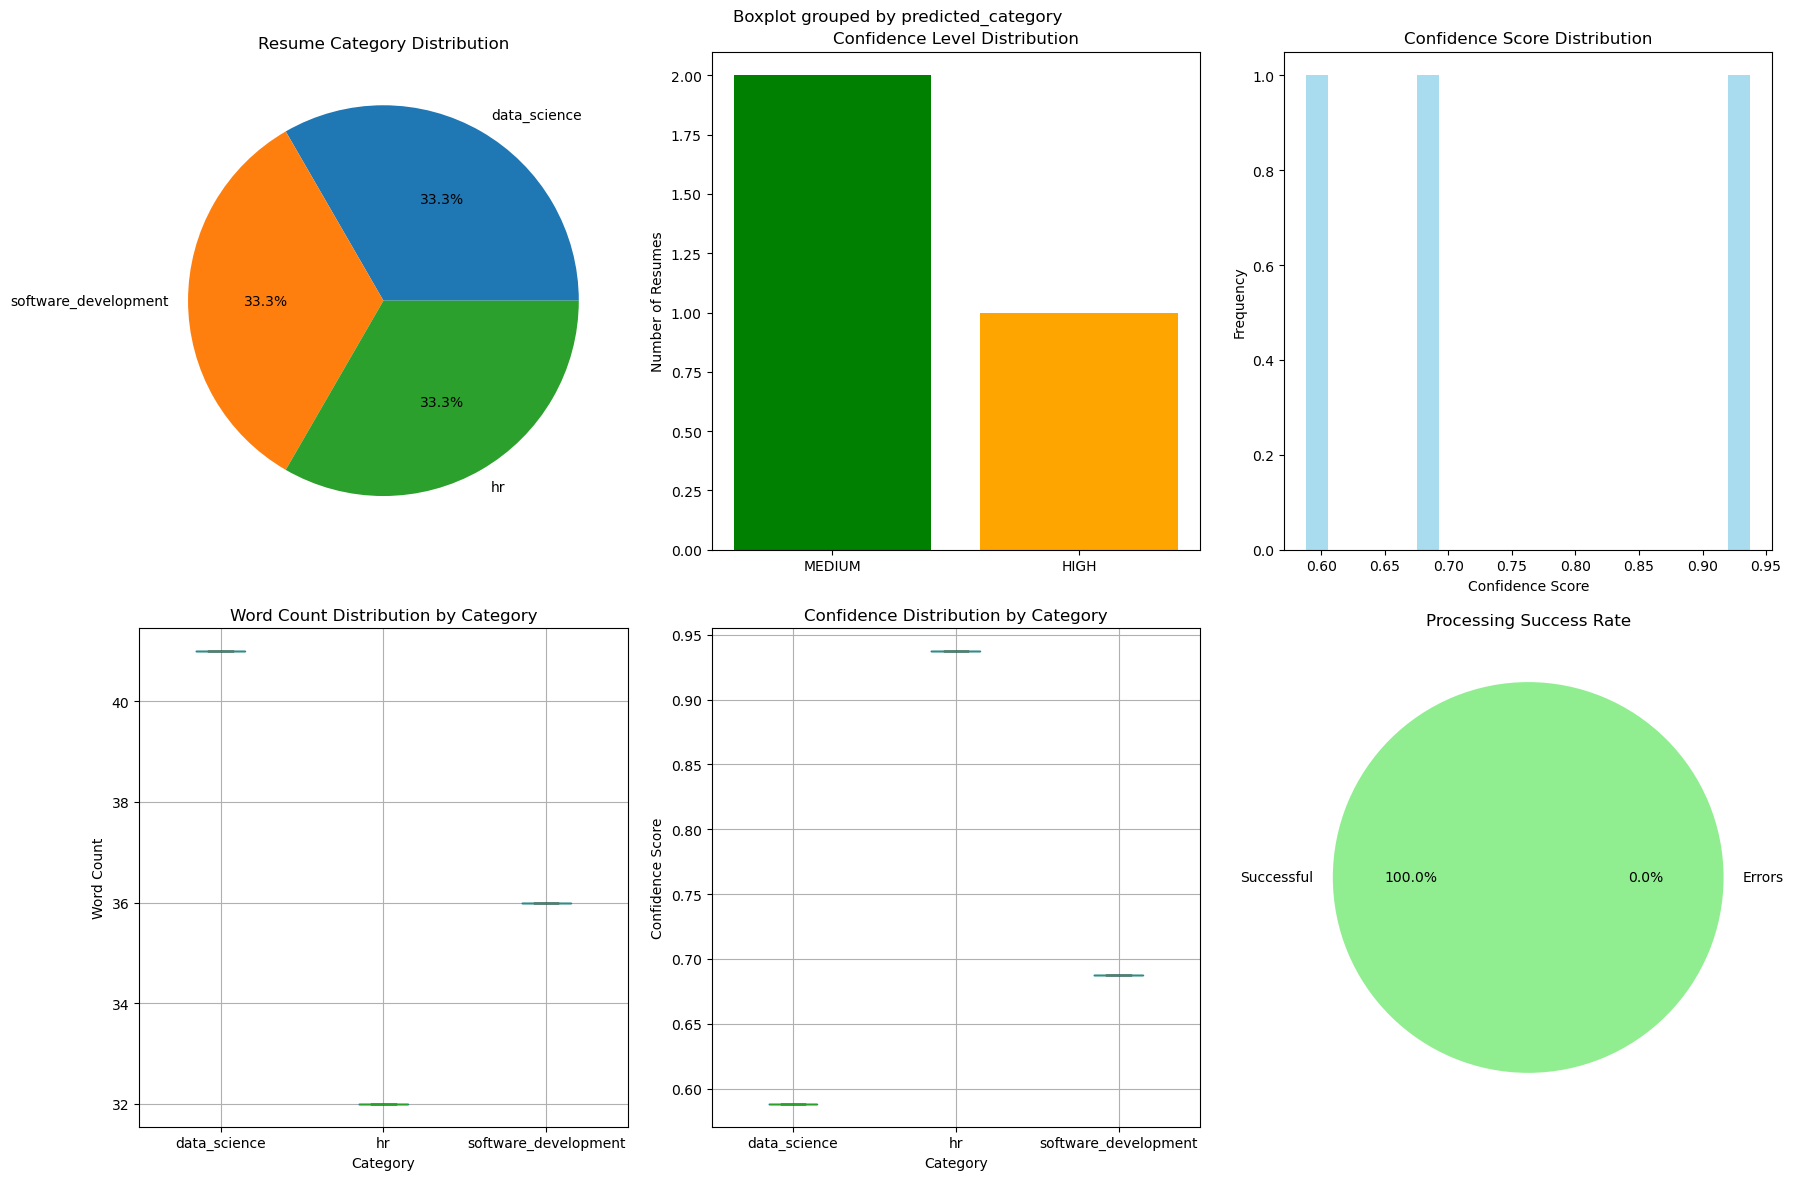

In [22]:
def create_detailed_report(results_df, output_path='reports/resume_classification_report.xlsx'):
    
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        
        summary_data = {
            'Metric': [
                'Total Resumes Processed',
                'Successful Classifications', 
                'Success Rate (%)',
                'Average Confidence Score',
                'High Confidence Classifications',
                'Medium Confidence Classifications',
                'Low Confidence Classifications'
            ],
            'Value': [
                len(results_df),
                len(results_df[results_df['error'].isna()]),
                len(results_df[results_df['error'].isna()]) / len(results_df) * 100,
                results_df['confidence'].mean(),
                len(results_df[results_df['confidence_level'] == 'HIGH']),
                len(results_df[results_df['confidence_level'] == 'MEDIUM']),
                len(results_df[results_df['confidence_level'] == 'LOW'])
            ]
        }
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        
        detailed_cols = ['filename', 'predicted_category', 'confidence', 'confidence_level', 'word_count', 'error']
        results_df[detailed_cols].to_excel(writer, sheet_name='Detailed Results', index=False)
        
        category_breakdown = results_df.groupby(['predicted_category', 'confidence_level']).size().unstack(fill_value=0)
        category_breakdown.to_excel(writer, sheet_name='Category Breakdown')
        
        low_confidence = results_df[results_df['confidence_level'] == 'LOW'][detailed_cols]
        low_confidence.to_excel(writer, sheet_name='Manual Review Required', index=False)
    
    print(f"Detailed report saved to: {output_path}")

def create_visual_dashboard(results_df):
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    category_counts = results_df['predicted_category'].value_counts()
    axes[0,0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
    axes[0,0].set_title('Resume Category Distribution')
    
    conf_counts = results_df['confidence_level'].value_counts()
    axes[0,1].bar(conf_counts.index, conf_counts.values, color=['green', 'orange', 'red'])
    axes[0,1].set_title('Confidence Level Distribution')
    axes[0,1].set_ylabel('Number of Resumes')
    
    axes[0,2].hist(results_df['confidence'], bins=20, alpha=0.7, color='skyblue')
    axes[0,2].set_title('Confidence Score Distribution')
    axes[0,2].set_xlabel('Confidence Score')
    axes[0,2].set_ylabel('Frequency')

    results_df.boxplot(column='word_count', by='predicted_category', ax=axes[1,0])
    axes[1,0].set_title('Word Count Distribution by Category')
    axes[1,0].set_xlabel('Category')
    axes[1,0].set_ylabel('Word Count')
    
    results_df.boxplot(column='confidence', by='predicted_category', ax=axes[1,1])
    axes[1,1].set_title('Confidence Distribution by Category')
    axes[1,1].set_xlabel('Category')
    axes[1,1].set_ylabel('Confidence Score')

    success_rate = len(results_df[results_df['error'].isna()]) / len(results_df) * 100
    error_rate = 100 - success_rate
    axes[1,2].pie([success_rate, error_rate], labels=['Successful', 'Errors'], 
                  autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
    axes[1,2].set_title('Processing Success Rate')
    
    plt.tight_layout()
    plt.savefig('reports/classification_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

test_results_df = pd.DataFrame(test_results)
create_detailed_report(test_results_df)
create_visual_dashboard(test_results_df)

In [2]:
class ModelMonitor:
    
    def __init__(self):
        self.performance_log = []
    
    def log_prediction(self, filename, true_category, predicted_category, confidence, timestamp=None):
        if timestamp is None:
            timestamp = pd.Timestamp.now()
        
        self.performance_log.append({
            'timestamp': timestamp,
            'filename': filename,
            'true_category': true_category,
            'predicted_category': predicted_category,
            'confidence': confidence,
            'correct': true_category == predicted_category
        })
    
    def get_performance_metrics(self, time_window_days=30):
        if not self.performance_log:
            return None
        
        df = pd.DataFrame(self.performance_log)
        cutoff_date = pd.Timestamp.now() - pd.Timedelta(days=time_window_days)
        recent_df = df[df['timestamp'] >= cutoff_date]
        
        if len(recent_df) == 0:
            return None
        
        metrics = {
            'total_predictions': len(recent_df),
            'accuracy': recent_df['correct'].mean(),
            'average_confidence': recent_df['confidence'].mean(),
            'category_accuracy': recent_df.groupby('true_category')['correct'].mean().to_dict(),
            'low_confidence_rate': (recent_df['confidence'] < 0.5).mean()
        }
        
        return metrics
    
    def plot_performance_trend(self):
        if not self.performance_log:
            print("No performance data available")
            return
        
        df = pd.DataFrame(self.performance_log)
        df['date'] = df['timestamp'].dt.date
        
        daily_metrics = df.groupby('date').agg({
            'correct': 'mean',
            'confidence': 'mean'
        }).reset_index()
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        ax1.plot(daily_metrics['date'], daily_metrics['correct'], marker='o')
        ax1.set_title('Daily Accuracy Trend')
        ax1.set_ylabel('Accuracy')
        ax1.grid(True)
        
        ax2.plot(daily_metrics['date'], daily_metrics['confidence'], marker='o', color='orange')
        ax2.set_title('Daily Average Confidence Trend')
        ax2.set_ylabel('Average Confidence')
        ax2.set_xlabel('Date')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
